# Experimental: Self-Supervised Learning

Our goal will be to teach a neural network to learn how to solve an airfoil optimization problem. This notebook uses a surrogate model of the actual CFD solver for development purposes.

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import pathlib
import itertools
import jenn
from scipy.stats import qmc
from jenn.core.cost import Loss

In [3]:
SEED = 123

## Parabolic Test Function

_First, we will test that the process is working for a parabolic test function._

### Training Data

In [4]:
m = 100
lb = -5
ub = 5
x_train = x1 = np.linspace(lb, ub, m).reshape((1, -1)) 
x2 = -1/2 * x1  # optimum given x1
y_train = x1 ** 2 + x2 ** 2 + x1 * x2

### Custom Loss

In [5]:
class CustomLoss(Loss): 
    """Parabola."""

    def denormalize(self, Y_pred: np.ndarray) -> np.ndarray:
        x_norm = self.X 
        y_norm = Y_pred 
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
        return x, y
        
    def evaluate(self, Y_pred: np.ndarray) -> np.ndarray:
        x, y = self.denormalize(Y_pred)
        return x ** 2 + y ** 2 + x * y

    def evaluate_partials(self, Y_pred: np.ndarray) -> np.ndarray:
        """Compute partials for each airfoil shape."""
        x, y = self.denormalize(Y_pred)
        return 2 * y + x

### Training

Training can be done in one line of code. 

In [6]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0], 7, 7, y_train.shape[0]],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-3,
    lambd=1e-4, 
    beta1=0.8,
    beta2=0.7,
    max_iter=2000,
    is_normalize=False,
    is_backtracking=True,
    is_verbose=False, 
    random_state=SEED, 
    custom_loss=CustomLoss,
    N1_max=25,
    N2_max=25, 
)

CPU times: user 799 ms, sys: 9.34 ms, total: 809 ms
Wall time: 993 ms


### Visualization

#### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

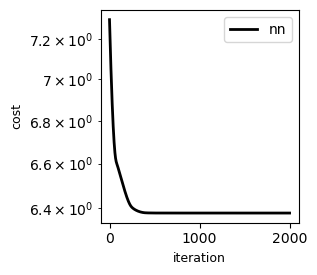

In [7]:
jenn.utils.plot.convergence(histories=[nn.history], legend=["nn"])

#### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

In [8]:
x1 = x_train
x2 = nn.predict(x_train) 
y_pred = x1 ** 2 + x2 ** 2 + x1 * x2

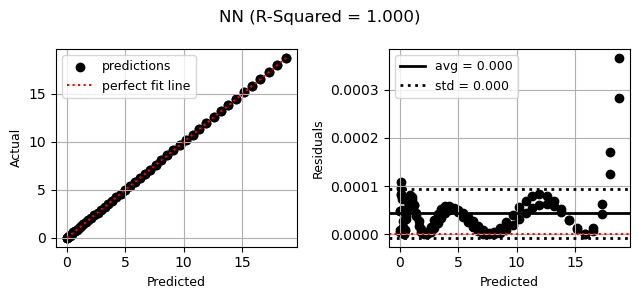

In [9]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train, 
    y_pred=y_pred,
    title="NN"
)

## Airfoil Shape Optimization 

We now test SSL on a small yet representative airfoil shape optimization problem. Given some desired flight condition, we seek to use SSL in order to predict the optimal airfoil shape. 

### Training Data

In [4]:
df_train = pd.read_csv("DATABASE_OF_OPTIMIZED_SHAPEVARS.csv", index_col=0)

In [5]:
x_labels = ["M", "CL"]
y_labels = [f"X{i}" for i in range(14)]

In [6]:
x_train = df_train[x_labels].values.T
y_train = df_train[y_labels].values.T

In [7]:
n_x = len(x_labels)
n_y = len(y_labels)

<Axes: xlabel='M', ylabel='CL'>

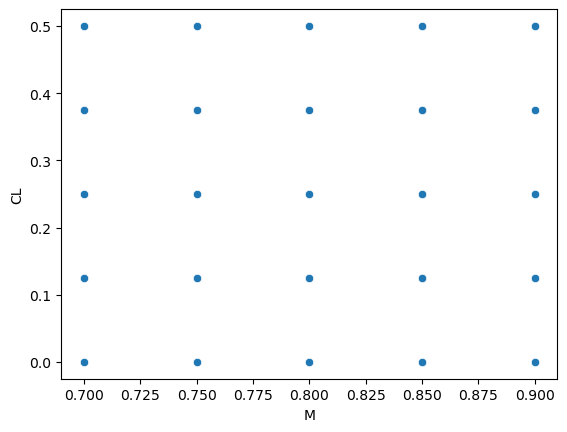

In [8]:
sns.scatterplot(
    data=df_train, 
    x="M", 
    y="CL",  
)

### CFD Function Call

In [9]:
surrogate_model = jenn.model.NeuralNet(
        layer_sizes=[16, [16] * 5, 1]
    ).load('gnn_parameters_7500.json') 

In [10]:
def cfd_model(x: np.ndarray, y: np.ndarray) -> tuple[np.ndarray, np.ndarray]: 
    """Evaluate CFD surrogate model. 

    :param x: array of shape (2, m) containing [M, CL]
    :param y: array of shape (14, m) containing shape variables 
    :returns: CD, dCDdy 
    """
    CD, CD_partials = surrogate_model.evaluate(np.concatenate([x, y], axis=0)) 
    mask = CD[0] < 0
    CD[:, mask] = 0
    CD_partials[:, 2:, mask] = 0
    return CD, CD_partials[:, 2:, :]

### Custom Loss

_We'll use a surrogate of the model for illustration but, in practice, one would use the actual CFD model._

In [173]:
SQUARED = True

In [174]:
class CFDLoss(Loss): 
    """Minimize drag."""

    cd_std = None 
    
    def _display(self, x, CD, loss, penalty): 
        """Display progress."""
        print()
        for i in range(x.shape[-1]):  # be careful: the order here doesn't necessary match the training data order (due to shuffling)
            M = x[0, i]
            CL = x[1, i]
            p = penalty[:, i].sum()
            l = loss[0, i]
            case_id = lookup_case_id(M, CL)
            print(f"i: {i:4n} | CASE: {case_id:4n} | M = {M: 6.4f} | Cl = {CL: 6.4f} | Cd = {CD[0, i]: 6.4f} | Loss = {l: 8.4f} | penalty = {p: 6.2f}")
        print()

    def evaluate(self, Y_pred: np.ndarray, lb: float = -0.01, ub: float = 0.01, r_p: float = 1e4) -> np.ndarray:
        """Compute drag for each airfoil shape."""
        
        ###############
        # Denormalize # 
        ###############
        
        x_norm = self.X  # flight conditions 
        y_norm = Y_pred  # shape variables
        
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
 
        #################
        # Compute Drag # 
        ################
        
        cd = cfd_model(x, y)[0] 

        if self.cd_std is None: 
            self.cd_std = np.std(cd)
 
        ###################
        # Compute Penalty # 
        ###################

        upper_bound = np.maximum(0, (y - ub) / (ub - lb)) ** 2
        lower_bound = np.minimum(0, (y - lb) / (ub - lb)) ** 2
        
        penalty = r_p * (lower_bound + upper_bound)

        ################
        # Compute Loss # 
        ################

        if SQUARED:
            loss = (cd / self.cd_std) ** 2 / y.shape[0]
        else: 
            loss = cd / self.cd_std / y.shape[0]

        # self._display(x, drag, loss, penalty)
        
        return loss + penalty

    def evaluate_partials(self, Y_pred: np.ndarray, lb: float = -0.01, ub: float = 0.01, r_p: float = 1e4) -> np.ndarray:
        """Compute partials of loss w.r.t. airfoil shape."""
        
        ###############
        # Denormalize # 
        ###############
        
        x_norm = self.X  # flight conditions 
        y_norm = Y_pred  # shape variables
        
        x_ref = self.data.x_ref
        y_ref = self.data.y_ref
        
        x_scale = self.data.x_scale
        y_scale = self.data.y_scale
        
        x = x_ref + x_norm * x_scale
        y = y_ref + y_norm * y_scale 
 
        #########################
        # Compute Drag Partials # 
        #########################

        cd, cd_partials = cfd_model(x, y)
 
        ############################
        # Compute Penalty Partials # 
        ############################
        
        upper_bound_partials = 2 * np.maximum(0, (y - ub) / (ub - lb)) / (ub - lb)
        lower_bound_partials = 2 * np.minimum(0, (y - lb) / (ub - lb)) / (ub - lb)
        
        penalty_partials = r_p * (lower_bound_partials + upper_bound_partials)
 
        ######################
        # Normalize Partials # -> df/dy_norm = df/dy * dy/dy_norm where dy/dy_norm = y_scale
        ######################

        if SQUARED:
            normalized_loss_partials = 2 * (cd / self.cd_std) * cd_partials / self.cd_std / y.shape[0] * y_scale 
        else: 
            normalized_loss_partials = cd_partials / self.cd_std / y.shape[0] * y_scale 
            
        normalized_penalty_partials = penalty_partials * y_scale 
        
        return normalized_loss_partials + normalized_penalty_partials

### Training

In [175]:
n_x, m = x_train.shape 
n_y, _ = y_train.shape  # y_train not needed in SSL

#### SSL

In [176]:
%%time
ssl = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0]] + [28] * 2 + [y_train.shape[0]]
).fit( 
    x=x_train, 
    y=y_train, 
    alpha=1e-3,
    lambd=1e-6,
    beta1=0.9,
    beta2=0.999,
    max_count=3,
    max_iter=5000,
    is_warmstart=False, 
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=False, 
    random_state=SEED, 
    custom_loss=CFDLoss, 
    epsilon_absolute=1e-6,  # abs(cost[-1] - cost[-2]) < epsilon_absolute * cost_history[0]
    epsilon_relative=1e-6,  # abs(cost[-1] - cost[-2]) / abs(float(cost[-1])) < epsilon_relative
    N1_max=100,
    N2_max=100,
    tol=1e-6, 
    shuffle=False
)

CPU times: user 12.2 s, sys: 125 ms, total: 12.3 s
Wall time: 15.1 s


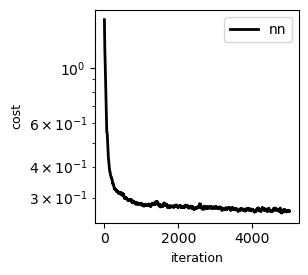

In [177]:
jenn.utils.plot.convergence(histories=[ssl.history], legend=["nn"])

In [178]:
ssl.predict(np.array([[0.7, 0.8, 0.9], [0.25, 0.375, 0.5]])) # visually inspect to ensure airfoil shapes are different across flight regimes

array([[ 0.00365196, -0.00409269, -0.00965302],
       [-0.00086676, -0.00704833, -0.00987506],
       [-0.00167745, -0.00505282, -0.00995361],
       [ 0.00252095, -0.00369197, -0.00977739],
       [-0.0018856 , -0.00797713, -0.00761161],
       [-0.00365025, -0.00715008, -0.00848498],
       [-0.00049515, -0.00631987, -0.00931444],
       [ 0.00327528, -0.00413691, -0.00984359],
       [-0.00343517, -0.00810612, -0.00989527],
       [-0.00212913, -0.00685494, -0.00982149],
       [ 0.00749615, -0.00057906, -0.0099019 ],
       [ 0.00859586,  0.00243378, -0.00948354],
       [ 0.00799221,  0.00779695, -0.00694366],
       [-0.00083658,  0.0037293 ,  0.0012637 ]])

#### Naive

In [23]:
naive = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0]] + [28] * 2 + [y_train.shape[0]]
).fit( 
    x=x_train, 
    y=y_train, 
    alpha=1e-2,
    lambd=1e-6,
    beta1=0.9,
    beta2=0.99,
    max_count=7,
    max_iter=2000,
    is_warmstart=False, 
    is_normalize=True,  
    is_backtracking=True, 
    is_verbose=False, 
    random_state=SEED, 
    epsilon_absolute=1e-12,  # abs(cost[-1] - cost[-2]) < epsilon_absolute * cost_history[0]
    epsilon_relative=1e-12,  # abs(cost[-1] - cost[-2]) / abs(float(cost[-1])) < epsilon_relative
    N1_max=5,
    N2_max=5,
    tol=1e-12
)

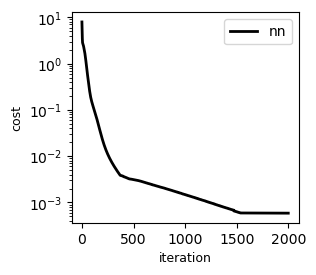

In [24]:
jenn.utils.plot.convergence(histories=[naive.history], legend=["nn"])

### Goodness of Fit

_Goodness of fit is perfect, implying that SSL is working (at least for an easy test function)._

#### SSL vs. CFD Surrogate

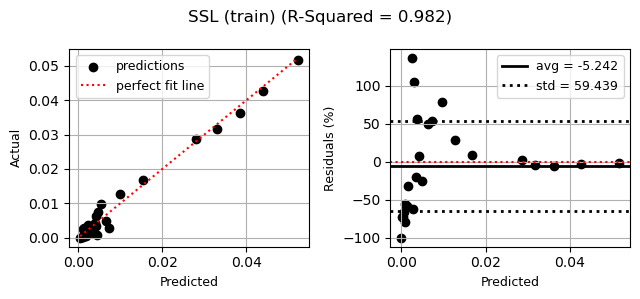

In [179]:
jenn.utils.plot.goodness_of_fit(
    y_true=cfd_model(x=x_train, y=y_train)[0], 
    y_pred=cfd_model(x=x_train, y=ssl.predict(x_train))[0],
    title="SSL (train)", 
    percent_residuals=True
)

#### SSL vs. Train Data

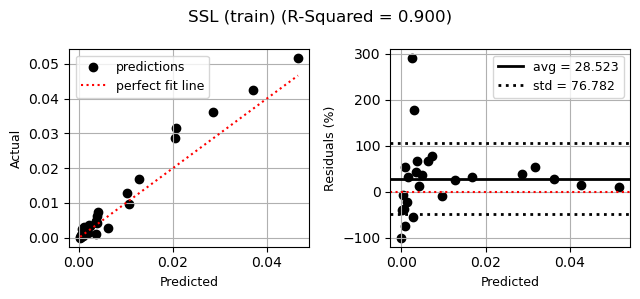

In [180]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_train["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=ssl.predict(x_train))[0],
    title="SSL (train)", 
    percent_residuals=True
)

### Naive vs. Train Data

In [159]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_train["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=naive.predict(x_train))[0],
    title="Naive (train)", 
    percent_residuals=True
)

NameError: name 'naive' is not defined

### CFD Surrogate vs. Train Data

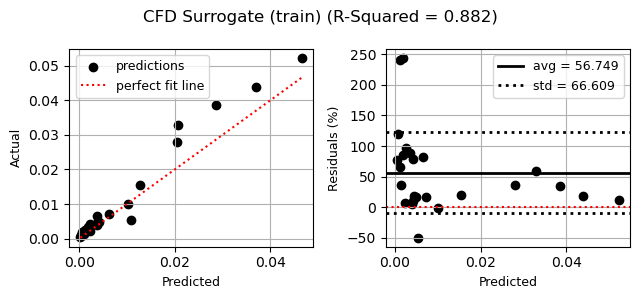

In [28]:
jenn.utils.plot.goodness_of_fit(
    y_true=df_train["CD"].values.reshape((1, -1)), 
    y_pred=cfd_model(x=x_train, y=y_train)[0],
    title="CFD Surrogate (train)", 
    percent_residuals=True
)

#### Shape Variables

##### SSL

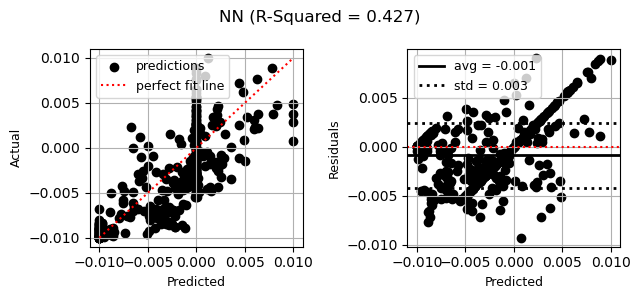

In [29]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train.ravel(),
    y_pred=ssl.predict(x_train).ravel(),
    title="NN", 
    percent_residuals=False
)

##### Naive

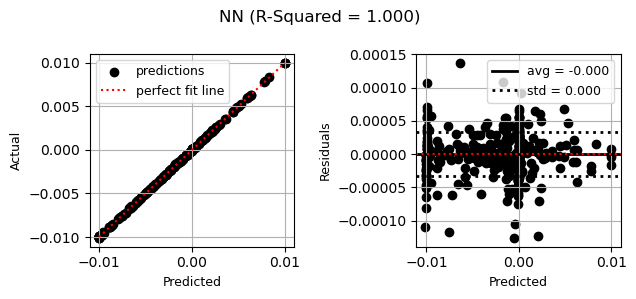

In [30]:
jenn.utils.plot.goodness_of_fit(
    y_true=y_train.ravel(),
    y_pred=naive.predict(x_train).ravel(),
    title="NN", 
    percent_residuals=False
)